## Kreditriskmodell - Maskininlärning 

In [28]:
import pandas as pd
import numpy as np
import os, time, json, joblib
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, cross_val_predict
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.metrics import classification_report, recall_score, precision_score, roc_auc_score, confusion_matrix, average_precision_score, accuracy_score, f1_score, brier_score_loss, RocCurveDisplay
from xgboost import XGBClassifier

#### Läs data och bygg X, y

In [3]:
df = pd.read_csv("synthetic_credit_data.csv")

In [4]:
# Används bara låntagare för defaultmodell
bor = df[df["has_loan"] == 1].copy()

In [5]:
# Numeriska och kategoriska features
num_cols = ["age", "years_with_bank", "income", "credit_score", "dti", "missed_payments"]
cat_cols = ["employment_status", "housing"]

X = bor[num_cols + cat_cols]
y = bor["default"].astype(int)

#### Dela upp data i train/test-split

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

#### Preprocessing

In [7]:
preproc = ColumnTransformer([
    ("num", StandardScaler(), num_cols), 
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),  # one-hot för kategoriska
], remainder="drop")

#### Pipelines

In [10]:
# Alla modeller körs med samma preprocessing

pipelines = {}

# Logistic Regression
pipelines["logreg"] = Pipeline([
    ("prep", preproc),
    ("clf", LogisticRegression(max_iter=2000, class_weight="balanced", random_state= 42))
])

# Random Forest 
pipelines["rf"] = Pipeline([
    ("prep", preproc),
    ("clf", RandomForestClassifier(
        n_estimators=400, max_depth=None, min_samples_leaf=2,
        n_jobs=-1, random_state=42
    ))
])

# HistGradientBoosting 
pipelines["hgb"] = Pipeline([
    ("prep", preproc),
    ("clf", HistGradientBoostingClassifier(
        learning_rate=0.08, max_leaf_nodes=31, random_state=42
    ))
])

# XGBoost
pipelines["xgb"] = Pipeline([
        ("prep", preproc),
        ("clf", XGBClassifier(
            n_estimators=600, max_depth=4, learning_rate=0.05,
            subsample=0.9, colsample_bytree=0.9, reg_lambda=1.0,
            objective="binary:logistic", eval_metric="logloss",
            random_state=42, n_jobs=-1
        ))
    ])


#### Cross-Validation på träningsdata

In [11]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_results = {}

for name, pipe in pipelines.items():
    scores = cross_val_score(pipe, X_train, y_train, cv=cv, scoring="roc_auc", n_jobs=-1)
    cv_results[name] = scores
    print(f"{name:>6s} | ROC AUC (CV 5-fold): mean={scores.mean():.3f}  std={scores.std():.3f}")

logreg | ROC AUC (CV 5-fold): mean=0.682  std=0.053
    rf | ROC AUC (CV 5-fold): mean=0.620  std=0.042
   hgb | ROC AUC (CV 5-fold): mean=0.590  std=0.046
   xgb | ROC AUC (CV 5-fold): mean=0.589  std=0.045


#### Den modell som har högst ROC AUC i cross-validation tränas på hela träningsdatan

In [14]:
best_name = max(cv_results, key=lambda k: cv_results[k].mean())
best_cv_mean = cv_results[best_name].mean()
winner = pipelines[best_name]
print(f"Modellen som presterar bäst i CV mätt med ROC AUC är: {best_name} (mean ROC AUC={best_cv_mean:.3f})")

winner.fit(X_train, y_train)

Modellen som presterar bäst i CV mätt med ROC AUC är: logreg (mean ROC AUC=0.682)


Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'years_with_bank',
                                                   'income', 'credit_score',
                                                   'dti', 'missed_payments']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['employment_status',
                                                   'housing'])])),
                ('clf',
                 LogisticRegression(class_weight='balanced', max_iter=2000,
                                    random_state=42))])

#### Kalibrering + threshold-tuning

In [18]:
os.makedirs("models", exist_ok=True)
os.makedirs("reports", exist_ok=True)
stamp = time.strftime("%Y%m%d-%H%M%S")

In [20]:
# OOF-prob på train för threshold-tuning (ingen läckage mot test)
def oof_predict_proba(est, X, y, cv):
    try:
        proba = cross_val_predict(est, X, y, cv=cv, method="predict_proba")[:, 1]
    except Exception:
        scores = cross_val_predict(est, X, y, cv=cv, method="decision_function")
        smin, smax = scores.min(), scores.max()
        proba = (scores - smin) / (smax - smin + 1e-12)
    return proba

oof_proba = oof_predict_proba(winner, X_train, y_train, cv)

In [ ]:
# Tunad threshold: max F1 (alternativ: sätt recall-krav)
from sklearn.metrics import precision_recall_curve
prec, rec, thr = precision_recall_curve(y_train, oof_proba)
f1 = 2 * prec * rec / (prec + rec + 1e-9)
best_idx = np.nanargmax(f1)
best_thr = float(thr[best_idx])
print(f"\n Tunad threshold (max F1): {best_thr:.3f} | precision={prec[best_idx]:.3f} | recall={rec[best_idx]:.3f}")


 Tunad threshold (max F1): 0.465 | precision=0.363 | recall=0.692


In [ ]:
# Kalibrera sannolikheter (isotonic, 5-fold)
calibrated = CalibratedClassifierCV(winner, method="isotonic", cv=5)
calibrated.fit(X_train, y_train)

CalibratedClassifierCV(cv=5,
                       estimator=Pipeline(steps=[('prep',
                                                  ColumnTransformer(transformers=[('num',
                                                                                   StandardScaler(),
                                                                                   ['age',
                                                                                    'years_with_bank',
                                                                                    'income',
                                                                                    'credit_score',
                                                                                    'dti',
                                                                                    'missed_payments']),
                                                                                  ('cat',
                                                                                   OneHotEncoder(handle_unknown='ignore'),
                                                                                   ['employment_status',
                                                                                    'housing'])])),
                                                 ('clf',
                                                  LogisticRegression(class_weight='balanced',
                                                                     max_iter=2000,
                                                                     random_state=42))]),
                       method='isotonic')

#### TEST-utvärdering

In [27]:
# Proba på TEST (kalibrerade)
y_proba_test = calibrated.predict_proba(X_test)[:,1]
y_pred_05 = (y_proba_test >= 0.5).astype(int)
y_pred_tune = (y_proba_test >= best_thr).astype(int)


def eval_on_test(y_true, y_pred, y_proba, label):
    print(f"\n=== TEST-metrik ({label}) ===")
    print(f"ROC AUC : {roc_auc_score(y_true, y_proba):.4f}")
    print(f"PR  AUC : {average_precision_score(y_true, y_proba):.4f}")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"Recall  : {recall_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred, zero_division=0):.4f}")
    print(f"F1      : {f1_score(y_true, y_pred):.4f}")
    print(f"Brier   : {brier_score_loss(y_true, y_proba):.4f}")
    print("Confusion matrix:\n", confusion_matrix(y_true, y_pred))
    print("Classification report:\n", classification_report(y_true, y_pred, digits=3))

eval_on_test(y_test, y_pred_05,   y_proba_test, "threshold=0.50 (kalibrerad)")
eval_on_test(y_test, y_pred_tune, y_proba_test, f"threshold={best_thr:.3f} (tunad via OOF)")



=== TEST-metrik (threshold=0.50 (kalibrerad)) ===
ROC AUC : 0.6925
PR  AUC : 0.4392
Accuracy: 0.7568
Recall  : 0.2321
Precision: 0.5417
F1      : 0.3250
Brier   : 0.1726
Confusion matrix:
 [[155  11]
 [ 43  13]]
Classification report:
               precision    recall  f1-score   support

           0      0.783     0.934     0.852       166
           1      0.542     0.232     0.325        56

    accuracy                          0.757       222
   macro avg      0.662     0.583     0.588       222
weighted avg      0.722     0.757     0.719       222


=== TEST-metrik (threshold=0.465 (tunad via OOF)) ===
ROC AUC : 0.6925
PR  AUC : 0.4392
Accuracy: 0.7568
Recall  : 0.2679
Precision: 0.5357
F1      : 0.3571
Brier   : 0.1726
Confusion matrix:
 [[153  13]
 [ 41  15]]
Classification report:
               precision    recall  f1-score   support

           0      0.789     0.922     0.850       166
           1      0.536     0.268     0.357        56

    accuracy                   

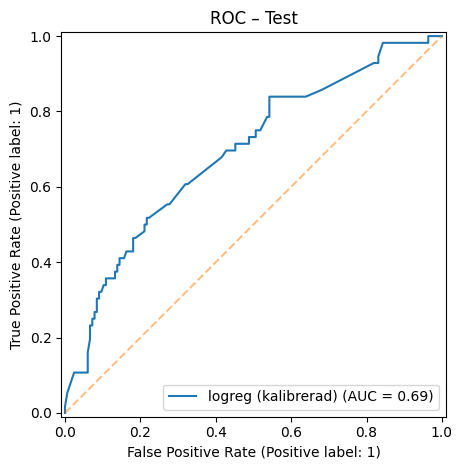

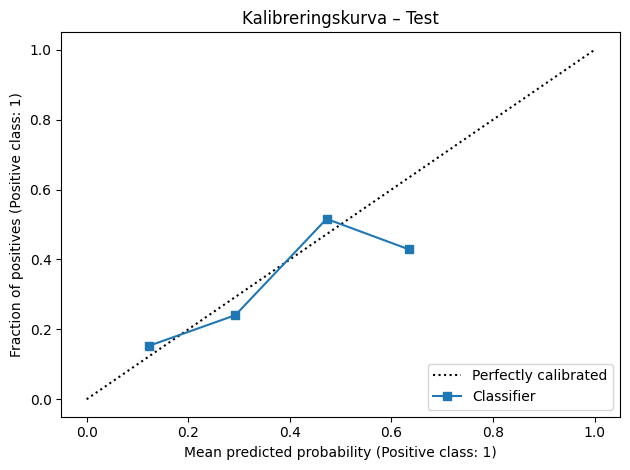

In [29]:
#Plotta ROC + Kalibreringskurva
RocCurveDisplay.from_predictions(y_test, y_proba_test, name=f"{best_name} (kalibrerad)")
plt.plot([0,1],[0,1],"--",alpha=0.5); plt.title("ROC – Test"); plt.tight_layout(); plt.show()

CalibrationDisplay.from_predictions(y_test, y_proba_test)
plt.title("Kalibreringskurva – Test"); plt.tight_layout(); plt.show()


In [32]:
# Spara kalibrerad modell
model_path = f"models/credit_risk_{best_name}_calibrated_{stamp}.joblib"
joblib.dump(calibrated, model_path)

print(f"\n Kalibrerad modell sparad: {model_path}")


 Kalibrerad modell sparad: models/credit_risk_logreg_calibrated_20250923-133019.joblib


In [33]:
# Sammanfattning
summary = {
    "best_model_cv": best_name,
    "cv_mean_scores": {k: float(v.mean()) for k, v in cv_results.items()},
    "threshold_tuned_f1": best_thr,
    "test_metrics_thr_05": {
        "roc_auc": float(roc_auc_score(y_test, y_proba_test)),
        "pr_auc": float(average_precision_score(y_test, y_proba_test)),
        "accuracy": float(accuracy_score(y_test, y_pred_05)),
        "recall": float(recall_score(y_test, y_pred_05)),
        "precision": float(precision_score(y_test, y_pred_05, zero_division=0)),
        "f1": float(f1_score(y_test, y_pred_05)),
        "brier": float(brier_score_loss(y_test, y_proba_test)),
    },
    "test_metrics_thr_tuned": {
        "roc_auc": float(roc_auc_score(y_test, y_proba_test)),  # AUC oberoende av threshold
        "pr_auc": float(average_precision_score(y_test, y_proba_test)),
        "accuracy": float(accuracy_score(y_test, y_pred_tune)),
        "recall": float(recall_score(y_test, y_pred_tune)),
        "precision": float(precision_score(y_test, y_pred_tune, zero_division=0)),
        "f1": float(f1_score(y_test, y_pred_tune)),
        "brier": float(brier_score_loss(y_test, y_proba_test)),
        "threshold": best_thr
    },
    "timestamp": stamp,
    "n_train": int(len(X_train)),
    "n_test": int(len(X_test)),
    "num_features": num_cols,
    "cat_features": cat_cols
}
os.makedirs("reports", exist_ok=True)
with open(f"reports/test_summary_calibrated_{stamp}.json", "w", encoding="utf-8") as f:
    json.dump(summary, f, ensure_ascii=False, indent=2)

print(f"Rapport sparad: reports/test_summary_calibrated_{stamp}.json")

Rapport sparad: reports/test_summary_calibrated_20250923-133019.json
